In [1]:
#IMPORT LIBRARIES
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn import tree
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from keras.models import Sequential
from keras import models
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_context("talk")
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from keras import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import itertools
from sklearn.preprocessing import LabelBinarizer
from keras.utils.np_utils import to_categorical
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("fourth.csv", header = None)
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

In [3]:
# ACCOUNTING FOR NA VALUES THAT SHIFTED PARTS OF DF IN WRONG POSITION
df2 = df.copy()
hey = df2[df2.isnull().any(axis=1)]
hey
hey2 = hey.iloc[:,3:9].shift(2, axis = 1)
addition = pd.concat([hey.iloc[:, :3], hey2, hey.iloc[:,7], hey.iloc[:,8]], axis = 1)

In [4]:
df = df[~df.isnull().any(axis=1)]

In [5]:
df = df[1:]

In [6]:
addition.columns = [0,1,2,3,4,5,6,7,8,9,10]

In [7]:
df = pd.concat([df, addition], axis = 0)

In [8]:
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
#GETTING RID OF ROW WITH MAJORITY NA VALUES
df = df[df.isnull().sum(axis=1) < 4]

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,10
0,Marcelo Guimaraes,Brazil,Age 38,175 cm,74 kg,14:57,564 reps,108 reps,160 reps,19:07,15730
1,David Humphrey,United States,Age 33,70 in,195 lb,157 reps,479 reps,105 reps,181 reps,19:58,19941
2,Steve Borghese,Canada,Age 48,180 cm,195 lb,14:04,571 reps,111 reps,200 reps,18:18,8965
3,Mickael Da Silva,Luxembourg,Age 27,180 cm,78 kg,147 reps,615 reps,111 reps,166 reps,16:43,16403
5,Kenny Turano,United States,Age 39,71 in,193 lb,13:02,586 reps,112 reps,200 reps,212 reps,11772
...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,Age 31,65 in,165 lb,14:05,618 reps,114 reps,200 reps,16:11,6387
19996,Daniele Pinto,Italy,Age 38,NaN,NaN,173 reps,588 reps,103 reps,196 reps,19:59,12941
19997,William Mehler,Sweden,Age 26,174 cm,69 kg,14:49,681 reps,84 reps,163 reps,17:21,15172
19998,Tomas Vrbecky,Czech Republic,Age 35,NaN,NaN,165 reps,486 reps,111 reps,200 reps,230 reps,17430


In [11]:
#RENAMING COLUMNS
df.columns = ["Name", "Country", "Age", "Height", "Weight", "20.1", "20.2", "20.3", "20.4", "20.5", "Rank"]

In [12]:
df[(df["Height"].isnull()) & df["Weight"].notnull()]

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank


In [13]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank
0,Marcelo Guimaraes,Brazil,Age 38,175 cm,74 kg,14:57,564 reps,108 reps,160 reps,19:07,15730
1,David Humphrey,United States,Age 33,70 in,195 lb,157 reps,479 reps,105 reps,181 reps,19:58,19941
2,Steve Borghese,Canada,Age 48,180 cm,195 lb,14:04,571 reps,111 reps,200 reps,18:18,8965
3,Mickael Da Silva,Luxembourg,Age 27,180 cm,78 kg,147 reps,615 reps,111 reps,166 reps,16:43,16403
5,Kenny Turano,United States,Age 39,71 in,193 lb,13:02,586 reps,112 reps,200 reps,212 reps,11772
...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,Age 31,65 in,165 lb,14:05,618 reps,114 reps,200 reps,16:11,6387
19996,Daniele Pinto,Italy,Age 38,NaN,NaN,173 reps,588 reps,103 reps,196 reps,19:59,12941
19997,William Mehler,Sweden,Age 26,174 cm,69 kg,14:49,681 reps,84 reps,163 reps,17:21,15172
19998,Tomas Vrbecky,Czech Republic,Age 35,NaN,NaN,165 reps,486 reps,111 reps,200 reps,230 reps,17430


In [14]:
# mix of cm and in, need to convert all into one unit
df["Height"]

0        175 cm
1         70 in
2        180 cm
3        180 cm
5         71 in
          ...  
19995     65 in
19996       NaN
19997    174 cm
19998       NaN
19999     75 in
Name: Height, Length: 19847, dtype: object

In [15]:
df["Age"] = df["Age"].apply(lambda x: x.split()[1])

In [16]:
# CAPITALIZING FIRST AND LAST NAME FOR ALL THE NAMES
df["Name"] = df["Name"].str.title()

In [17]:
# CONVERING ALL HEIGHT TO CM
test = df[~df["Height"].isna()]["Height"].str.split()
for i in test:
    if i[1] == "in":
        i[0] = float(i[0]) * 2.54
        i[1] = "cm"

In [18]:
test = test.apply(lambda x: x[0])

In [19]:
test = test.astype("float")

In [20]:
test.mean()

177.9408815392257

In [21]:
#FILLING NA HEIGHTS WITH THE AVERGAGE HEIGHT
df["Height"] = df["Height"].fillna("177.94")

In [22]:
df["Height"].apply(lambda x: float(x.split()[0])*2.54 if x[-2:] == "in" else None)

0           NaN
1        177.80
2           NaN
3           NaN
5        180.34
          ...  
19995    165.10
19996       NaN
19997       NaN
19998       NaN
19999    190.50
Name: Height, Length: 19847, dtype: float64

In [23]:
#FINAL CONVERSION FOR HEIGHT
def height_conversion(x):
    
    """PARAM X: A HEIGHT IN CM OR INCHES
       RETURNS: HEIGHT IN CM"""
    split = x.split()
    try:
        if split[1] == "in":
            result = float(split[0]) * 2.54
            return result
        else:
            result = float(split[0])
            return result
    except:
        return x

In [24]:
df["Height"] = df["Height"].apply(lambda x: height_conversion(x))

In [25]:
# all in cm
df.Height

0           175
1         177.8
2           180
3           180
5        180.34
          ...  
19995     165.1
19996    177.94
19997       174
19998    177.94
19999     190.5
Name: Height, Length: 19847, dtype: object

In [26]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank
0,Marcelo Guimaraes,Brazil,38,175,74 kg,14:57,564 reps,108 reps,160 reps,19:07,15730
1,David Humphrey,United States,33,177.8,195 lb,157 reps,479 reps,105 reps,181 reps,19:58,19941
2,Steve Borghese,Canada,48,180,195 lb,14:04,571 reps,111 reps,200 reps,18:18,8965
3,Mickael Da Silva,Luxembourg,27,180,78 kg,147 reps,615 reps,111 reps,166 reps,16:43,16403
5,Kenny Turano,United States,39,180.34,193 lb,13:02,586 reps,112 reps,200 reps,212 reps,11772
...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,31,165.1,165 lb,14:05,618 reps,114 reps,200 reps,16:11,6387
19996,Daniele Pinto,Italy,38,177.94,NaN,173 reps,588 reps,103 reps,196 reps,19:59,12941
19997,William Mehler,Sweden,26,174,69 kg,14:49,681 reps,84 reps,163 reps,17:21,15172
19998,Tomas Vrbecky,Czech Republic,35,177.94,NaN,165 reps,486 reps,111 reps,200 reps,230 reps,17430


In [27]:
#GETTING RID OF NA VALUES AND STARTING TO CONVERT EVERYTHING TO KG
trial = df[~df["Weight"].isna()]
trial["Weight"] = trial["Weight"].apply(lambda x: x.split()[0] if x.split()[1] == "kg" else float(x.split()[0])*0.453592)

In [28]:
# CHANGING THE DATA TYPE
trial["Weight"] = trial["Weight"].astype(float)

In [29]:
trial["Weight"].mean()

83.76819081036324

In [30]:
def weight_conversion(x):
    """PARAM X: WEIGHT IN LB OR KG
       RETURNS: WEIGHT IN KG"""
    split = x.split()
    try:
        if split[1] == "lb":
            result = float(split[0]) * 0.453592
            return result
        else:
            result = float(split[0])
            return result
    except:
        pass

In [31]:
df["Weight"] = df["Weight"].astype(str)

In [32]:
df["Weight"] = df["Weight"].apply(lambda x: weight_conversion(x))

In [33]:
#FILLING NA WEIGHT VALUES WITH THE AVERAGE WEIGHT IN KG
df.Weight = df.Weight.fillna(83.7681)

In [34]:
def first(x):
    """PARAM X: SCORE FOR 20.1
       RETURNS ADJUSTED SCORE DEPENDING ON WHETHER COMPLETED OR NOT"""
    x = x.split()
    if len(x) > 1:
        try:
            return x[0]
        except:
            pass
    else:
        try:
            result = x[0].split(":")
            result = (15 * 60) - int(result[0])*60 + int(result[1])
            result += 180
            return result
        except:
            pass
    

In [35]:
#GETTING RID OF NA
df = df[~df["20.1"].apply(lambda x: first(x)).isna()]

In [36]:
#APPLYING ABOVE FUNCTON
df["20.1"] = df["20.1"].apply(lambda x: first(x))

In [37]:
def second(x):
    """PARAM X: REPS FOR 20.2
       RETURNS INT FOR NUMBER OF REPS, GETS RID OF STRING NEXT TO NUMBER"""
    x = x.split()
    try:
        return int(x[0])
    except:
        return "delete"

In [38]:
# GETTING RID OF VALUES THAT WERE PASSED TO THE EXCEPT BLOCK
df = df[df["20.2"].apply(lambda x: second(x)) != "delete"]

In [39]:
#APPLYING FUNCTION TO THE COLUMN
df["20.2"] = df["20.2"].apply(lambda x: second(x))

In [40]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank
0,Marcelo Guimaraes,Brazil,38,175,74.000000,297,564,108 reps,160 reps,19:07,15730
1,David Humphrey,United States,33,177.8,88.450440,157,479,105 reps,181 reps,19:58,19941
2,Steve Borghese,Canada,48,180,88.450440,244,571,111 reps,200 reps,18:18,8965
3,Mickael Da Silva,Luxembourg,27,180,78.000000,147,615,111 reps,166 reps,16:43,16403
5,Kenny Turano,United States,39,180.34,87.543256,302,586,112 reps,200 reps,212 reps,11772
...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,31,165.1,74.842680,245,618,114 reps,200 reps,16:11,6387
19996,Daniele Pinto,Italy,38,177.94,83.768100,173,588,103 reps,196 reps,19:59,12941
19997,William Mehler,Sweden,26,174,69.000000,289,681,84 reps,163 reps,17:21,15172
19998,Tomas Vrbecky,Czech Republic,35,177.94,83.768100,165,486,111 reps,200 reps,230 reps,17430


In [41]:
def third(x):
    """PARAM X: SCORE FOR 20.3
       RETURNS ADJUSTED SCORE, ACCOUNTS FOR THOSE THAT DID NOT FINISH IN TIME LIMIT"""
    if ":" in x:
        new = re.findall(r'\d+\:\d\d', x)[0]
        new = new.split(":")
        result = 9*60 - (int(new[0]) * 60 + int(new[1]))
        return result + 165
    elif "-" in x:
        return "delete"
    else:
        return x.split()[0]

In [42]:
# GETTING RID OF VALUES THAT HAVE NOTHING IN THEM
df = df[df["20.3"].apply(lambda x: third(x)) != "delete"]

In [43]:
#APPLYING THE FUNCTION TO THE COLUMN
df["20.3"] = df["20.3"].apply(lambda x: third(x))

In [44]:
def fourth(x):
    """PARAM X: SCORE FOR 20.4
       RETURNS ADJUSTED SCORE, ACCOUNTS FOR THOSE THAT DID NOT FINISH IN TIME LIMIT"""
    if ":" in x:
        new = re.findall(r'\d+\:\d\d', x)[0]
        new = new.split(":")
        result = (20*60) - (int(new[0]) * 60 + int(new[1]))
        return result + 240
    elif "-" in x:
        return "delete"
    else:
        return x.split()[0]


In [45]:
# GETTING RID OF VALUES WITH NOTHING IN THEM
df = df[df["20.4"].apply(lambda x: fourth(x)) != "delete"]

In [46]:
#APPLYING THE FUNCTON TO THE COLUMN
df["20.4"] = df["20.4"].apply(lambda x: fourth(x))

In [47]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank
0,Marcelo Guimaraes,Brazil,38,175,74.000000,297,564,108,160,19:07,15730
1,David Humphrey,United States,33,177.8,88.450440,157,479,105,181,19:58,19941
2,Steve Borghese,Canada,48,180,88.450440,244,571,111,200,18:18,8965
3,Mickael Da Silva,Luxembourg,27,180,78.000000,147,615,111,166,16:43,16403
5,Kenny Turano,United States,39,180.34,87.543256,302,586,112,200,212 reps,11772
...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,31,165.1,74.842680,245,618,114,200,16:11,6387
19996,Daniele Pinto,Italy,38,177.94,83.768100,173,588,103,196,19:59,12941
19997,William Mehler,Sweden,26,174,69.000000,289,681,84,163,17:21,15172
19998,Tomas Vrbecky,Czech Republic,35,177.94,83.768100,165,486,111,200,230 reps,17430


In [48]:
df.isna().sum()

Name       0
Country    0
Age        0
Height     0
Weight     0
20.1       0
20.2       0
20.3       0
20.4       0
20.5       0
Rank       0
dtype: int64

In [49]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank
0,Marcelo Guimaraes,Brazil,38,175,74.000000,297,564,108,160,19:07,15730
1,David Humphrey,United States,33,177.8,88.450440,157,479,105,181,19:58,19941
2,Steve Borghese,Canada,48,180,88.450440,244,571,111,200,18:18,8965
3,Mickael Da Silva,Luxembourg,27,180,78.000000,147,615,111,166,16:43,16403
5,Kenny Turano,United States,39,180.34,87.543256,302,586,112,200,212 reps,11772
...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,31,165.1,74.842680,245,618,114,200,16:11,6387
19996,Daniele Pinto,Italy,38,177.94,83.768100,173,588,103,196,19:59,12941
19997,William Mehler,Sweden,26,174,69.000000,289,681,84,163,17:21,15172
19998,Tomas Vrbecky,Czech Republic,35,177.94,83.768100,165,486,111,200,230 reps,17430


In [50]:
def fifth(x):
    """PARAM X: SCORE FOR 20.4
       RETURNS ADJUSTED SCORE, ACCOUNTS FOR THOSE THAT DID NOT FINISH IN TIME LIMIT"""
    if ":" in x:
        new = re.findall(r'\d+\:\d\d', x)[0]
        new = new.split(":")
        result = (20*60) - (int(new[0]) * 60 + int(new[1]))
        return result + 240
    elif "-" in x:
        return "delete"
    else:
        return x.split()[0]


In [51]:
# GETTING RID OF VALUES WITH NOTHING IN THEM
df = df[df["20.5"].apply(lambda x: fifth(x)) != "delete"]

In [52]:
#APPLYING THE FUNCTION TO THE COLUMN
df["20.5"] = df["20.5"].apply(lambda x: fifth(x))

In [53]:
df.isna().sum()

Name       0
Country    0
Age        0
Height     0
Weight     0
20.1       0
20.2       0
20.3       0
20.4       0
20.5       0
Rank       0
dtype: int64

In [54]:
df.Rank = df.Rank.astype(int)

In [55]:
df.dtypes

Name        object
Country     object
Age         object
Height      object
Weight     float64
20.1        object
20.2         int64
20.3        object
20.4        object
20.5        object
Rank         int64
dtype: object

In [56]:
df.columns

Index(['Name', 'Country', 'Age', 'Height', 'Weight', '20.1', '20.2', '20.3',
       '20.4', '20.5', 'Rank'],
      dtype='object')

In [57]:
def classification(x):
    """PARAM X: RANKING
       RETURNS APPROPRIATE CLASS OF RANKING"""
    if x <= 10:
        return "Top 10"
    elif x > 10 and x <= 50:
        return "Top 50"
    elif x > 50 and x <= 200:
        return "Top 200"
    elif x > 200 and x <= 500:
        return "200 - 500"
    elif x > 500 and x <= 1000:
        return "500 - 1,000"
    elif x > 1000 and x <= 2500:
        return "1,000 - 2,500"
    elif x > 2500 and x <= 5000:
        return "2,500 - 5,000"
    elif x > 5000 and x <= 7500:
        return "5,000 - 7,500"
    elif x > 7500 and x <= 10000:
        return "7,500 - 10,000"
    elif x > 10000 and x <= 12500:
        return "10,000 - 12,500"
    elif x > 12500 and x <= 15000:
        return "12,500 - 15,000"
    elif x > 15000 and x <= 17500:
        return "15,000 - 17,500"
    elif x > 17500 and x <= 20000:
        return "17500 - 20,000"

In [58]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank
0,Marcelo Guimaraes,Brazil,38,175,74.000000,297,564,108,160,293,15730
1,David Humphrey,United States,33,177.8,88.450440,157,479,105,181,242,19941
2,Steve Borghese,Canada,48,180,88.450440,244,571,111,200,342,8965
3,Mickael Da Silva,Luxembourg,27,180,78.000000,147,615,111,166,437,16403
5,Kenny Turano,United States,39,180.34,87.543256,302,586,112,200,212,11772
...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,31,165.1,74.842680,245,618,114,200,469,6387
19996,Daniele Pinto,Italy,38,177.94,83.768100,173,588,103,196,241,12941
19997,William Mehler,Sweden,26,174,69.000000,289,681,84,163,399,15172
19998,Tomas Vrbecky,Czech Republic,35,177.94,83.768100,165,486,111,200,230,17430


In [59]:
df["class"] = df["Rank"].apply(lambda x: classification(x))

In [60]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank,class
0,Marcelo Guimaraes,Brazil,38,175,74.000000,297,564,108,160,293,15730,"15,000 - 17,500"
1,David Humphrey,United States,33,177.8,88.450440,157,479,105,181,242,19941,"17500 - 20,000"
2,Steve Borghese,Canada,48,180,88.450440,244,571,111,200,342,8965,"7,500 - 10,000"
3,Mickael Da Silva,Luxembourg,27,180,78.000000,147,615,111,166,437,16403,"15,000 - 17,500"
5,Kenny Turano,United States,39,180.34,87.543256,302,586,112,200,212,11772,"10,000 - 12,500"
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,31,165.1,74.842680,245,618,114,200,469,6387,"5,000 - 7,500"
19996,Daniele Pinto,Italy,38,177.94,83.768100,173,588,103,196,241,12941,"12,500 - 15,000"
19997,William Mehler,Sweden,26,174,69.000000,289,681,84,163,399,15172,"15,000 - 17,500"
19998,Tomas Vrbecky,Czech Republic,35,177.94,83.768100,165,486,111,200,230,17430,"15,000 - 17,500"


In [61]:
#CHANGING DATA TYPES
df["Age"] = df["Age"].astype(int)

In [62]:
#CHANGING DATA TYPES
df[["20.1", "20.2", "20.3", "20.4", "20.5"]] = df[["20.1", "20.2", "20.3", "20.4", "20.5"]].astype(float)

# density plot


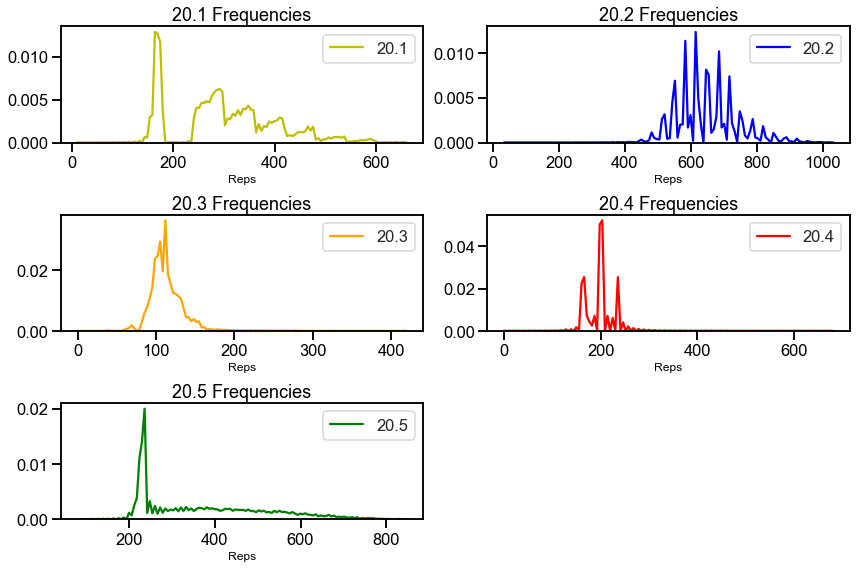

In [63]:
# Creating Density Plots for each event

fig, axes = plt.subplots(3,2, figsize = (12,8))
sns.set_style('whitegrid')
axes[0][0].set_title("20.1 Frequencies")
axes[0][0].set_xlabel("Reps", size = 12)
sns.kdeplot(df["20.1"], bw=0.5, color = 'y', ax = axes[0][0]);
axes[0][1].set_title("20.2 Frequencies")
axes[0][1].set_xlabel("Reps", size = 12)
sns.kdeplot(df["20.2"], bw=0.5, color = 'b', ax = axes[0][1]);
axes[1][0].set_title("20.3 Frequencies")
axes[1][0].set_xlabel("Reps", size = 12)
sns.kdeplot(df["20.3"], bw=0.5, color = 'orange', ax = axes[1][0]);
axes[1][1].set_title("20.4 Frequencies")
axes[1][1].set_xlabel("Reps", size = 12)
sns.kdeplot(df["20.4"], bw=0.5, color = 'r', ax = axes[1][1]);
axes[2][0].set_title("20.5 Frequencies")
axes[2][0].set_xlabel("Reps", size = 12)
sns.kdeplot(df["20.5"], bw=0.5, color = 'green', ax = axes[2][0]);
fig.delaxes(axes[2][1])



plt.tight_layout()



In [64]:
df["class"].unique()

array(['15,000 - 17,500', '17500 - 20,000', '7,500 - 10,000',
       '10,000 - 12,500', '5,000 - 7,500', '12,500 - 15,000', 'Top 200',
       '500 - 1,000', '1,000 - 2,500', '200 - 500', '2,500 - 5,000',
       'Top 50', 'Top 10'], dtype=object)

In [65]:
# Creating a correct order to display for scatterplots below

order = ['17500 - 20,000','15,000 - 17,500', '12,500 - 15,000', '10,000 - 12,500', '7,500 - 10,000',
         '5,000 - 7,500', '2,500 - 5,000', '1,000 - 2,500', 
         '500 - 1,000', '200 - 500', 'Top 200',
       'Top 50', 'Top 10']
order2 = order[::-1]

Text(0, 0.5, 'Class')

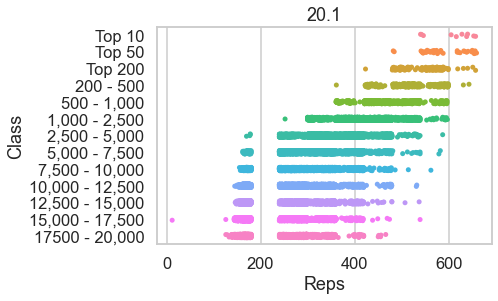

In [66]:
#class vs reps scatterplot for 20.1
sns.stripplot(df["20.1"], df["class"], order = order2);
plt.title("20.1");
plt.xlabel("Reps")
plt.ylabel("Class")

Text(0, 0.5, 'Class')

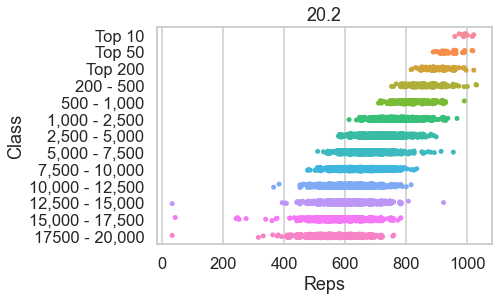

In [67]:
#class vs reps scatterplot for 20.2
sns.stripplot(df["20.2"], df["class"], order = order2)
plt.title("20.2")
plt.xlabel("Reps")
plt.ylabel("Class")

Text(0, 0.5, 'Class')

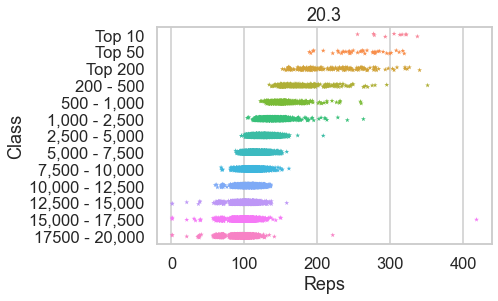

In [68]:
#class vs reps scatterplot for 20.3
sns.stripplot(df["20.3"], df["class"], order = order2, marker = '*')
plt.title("20.3")
plt.xlabel("Reps")
plt.ylabel("Class")

Text(0, 0.5, 'Class')

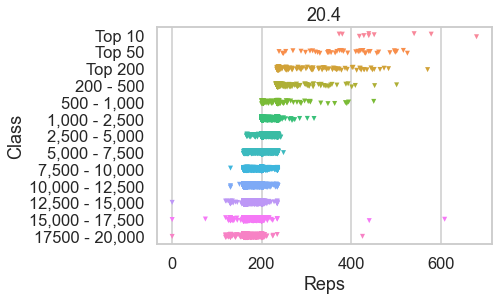

In [69]:
#class vs reps scatterplot for 20.4
sns.stripplot(df["20.4"], df["class"], order = order2, marker = 'v')
plt.title("20.4")
plt.xlabel("Reps")
plt.ylabel("Class")

Text(0, 0.5, 'Class')

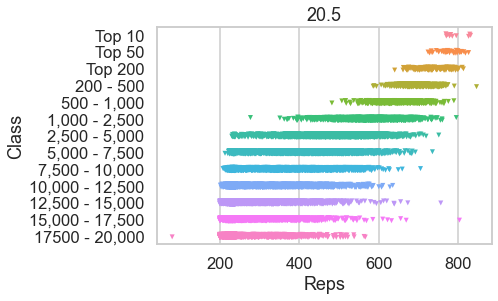

In [70]:
#class vs reps scatterplot for 20.5
sns.stripplot(df["20.5"], df["class"], order = order2, marker = "v")
plt.title("20.5")
plt.xlabel("Reps")
plt.ylabel("Class")

Text(0, 0.5, 'Class')

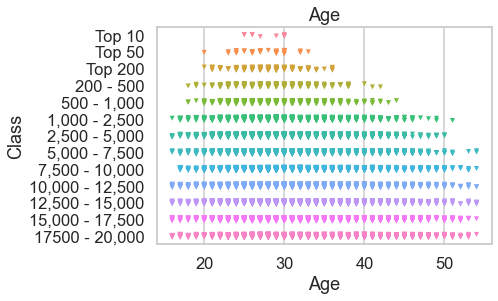

In [72]:
#Age vs class scatterplot
sns.stripplot(df["Age"], df["class"], order = order2, marker = "v")
plt.title("Age")
plt.xlabel("Age")
plt.ylabel("Class")

Text(0, 0.5, 'Class')

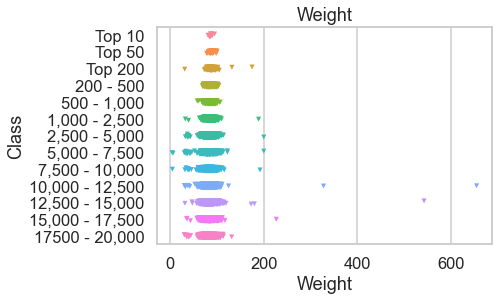

In [73]:
#Weight vs Class scatterplot
sns.stripplot(df["Weight"], df["class"], order = order2, marker = "v")
plt.title("Weight")
plt.xlabel("Weight")
plt.ylabel("Class")

Text(0, 0.5, 'Class')

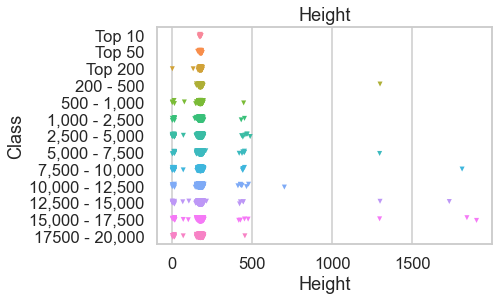

In [74]:
# Height vs class scatterplot
sns.stripplot(df["Height"], df["class"], order = order2, marker = "v")
plt.title("Height")
plt.xlabel("Height")
plt.ylabel("Class")

# Individuals weighing more than 150 kg is most likely a mistake

In [75]:
# getting rid of those weighing more than 150
df = df[df["Weight"] < 150]

In [76]:
df["Height"] = df["Height"].astype(float)

In [77]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank,class
0,Marcelo Guimaraes,Brazil,38,175.00,74.000000,297.0,564.0,108.0,160.0,293.0,15730,"15,000 - 17,500"
1,David Humphrey,United States,33,177.80,88.450440,157.0,479.0,105.0,181.0,242.0,19941,"17500 - 20,000"
2,Steve Borghese,Canada,48,180.00,88.450440,244.0,571.0,111.0,200.0,342.0,8965,"7,500 - 10,000"
3,Mickael Da Silva,Luxembourg,27,180.00,78.000000,147.0,615.0,111.0,166.0,437.0,16403,"15,000 - 17,500"
5,Kenny Turano,United States,39,180.34,87.543256,302.0,586.0,112.0,200.0,212.0,11772,"10,000 - 12,500"
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,31,165.10,74.842680,245.0,618.0,114.0,200.0,469.0,6387,"5,000 - 7,500"
19996,Daniele Pinto,Italy,38,177.94,83.768100,173.0,588.0,103.0,196.0,241.0,12941,"12,500 - 15,000"
19997,William Mehler,Sweden,26,174.00,69.000000,289.0,681.0,84.0,163.0,399.0,15172,"15,000 - 17,500"
19998,Tomas Vrbecky,Czech Republic,35,177.94,83.768100,165.0,486.0,111.0,200.0,230.0,17430,"15,000 - 17,500"


In [78]:
# isolating all ranges of realistic values to makea regression for when one value is realistic and the other isn't
regression_df = df[((df["Weight"] < 180) & ((df["Weight"] > 40))) & ((df["Height"] > 120) & ((df["Height"] < 250)))]

In [79]:
# A large majority of extreme values came from the height column, which is why we are using weight as the x variable
X = regression_df.Weight
y = regression_df.Height

In [80]:
# fitting
reg = LinearRegression().fit(np.array(X).reshape(-1,1), y)

In [81]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank,class
0,Marcelo Guimaraes,Brazil,38,175.00,74.000000,297.0,564.0,108.0,160.0,293.0,15730,"15,000 - 17,500"
1,David Humphrey,United States,33,177.80,88.450440,157.0,479.0,105.0,181.0,242.0,19941,"17500 - 20,000"
2,Steve Borghese,Canada,48,180.00,88.450440,244.0,571.0,111.0,200.0,342.0,8965,"7,500 - 10,000"
3,Mickael Da Silva,Luxembourg,27,180.00,78.000000,147.0,615.0,111.0,166.0,437.0,16403,"15,000 - 17,500"
5,Kenny Turano,United States,39,180.34,87.543256,302.0,586.0,112.0,200.0,212.0,11772,"10,000 - 12,500"
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Jonathan Leos,United States,31,165.10,74.842680,245.0,618.0,114.0,200.0,469.0,6387,"5,000 - 7,500"
19996,Daniele Pinto,Italy,38,177.94,83.768100,173.0,588.0,103.0,196.0,241.0,12941,"12,500 - 15,000"
19997,William Mehler,Sweden,26,174.00,69.000000,289.0,681.0,84.0,163.0,399.0,15172,"15,000 - 17,500"
19998,Tomas Vrbecky,Czech Republic,35,177.94,83.768100,165.0,486.0,111.0,200.0,230.0,17430,"15,000 - 17,500"


In [82]:
# there are more heights that are unrealistic compared to heights, finding all the competitors with unrealistic heights
# and realistic weights so we can use the regression we just built
new = df[((df["Height"] > 250) | (df["Height"] < 120)) & (df["Weight"] > 40)]

In [83]:
new

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank,class
61,Daniel Stearns,United States,40,15.24,88.450440,362.0,651.0,111.0,200.0,422.0,5995,"5,000 - 7,500"
227,Bryan Dormes,Honduras,28,2.00,63.502880,276.0,653.0,111.0,167.0,300.0,9951,"7,500 - 10,000"
255,Walter Osorio,Nicaragua,29,2.00,73.481904,177.0,601.0,101.0,165.0,260.0,14222,"12,500 - 15,000"
650,Alex Bennett,United Kingdom,27,416.56,68.000000,296.0,649.0,103.0,160.0,232.0,16097,"15,000 - 17,500"
811,Jean-Baptiste Manevy,France,27,477.52,102.000000,453.0,644.0,68.0,202.0,239.0,11830,"10,000 - 12,500"
...,...,...,...,...,...,...,...,...,...,...,...,...
19175,Alvaro Lopez,Panama,34,15.24,83.914520,463.0,754.0,136.0,202.0,601.0,1639,"1,000 - 2,500"
19407,Samuel Fowler,New Zealand,22,452.12,76.000000,328.0,698.0,122.0,167.0,459.0,6303,"5,000 - 7,500"
19534,Jonatas Corsi,Brazil,27,1730.00,75.000000,280.0,622.0,95.0,165.0,237.0,14218,"12,500 - 15,000"
19821,Peter Anderson,United States,39,12.70,92.986360,169.0,562.0,89.0,186.0,225.0,19528,"17500 - 20,000"


In [84]:
# setting df to only realistic height and weight values
df = df[(df["Height"] < 250) & (df["Height"] > 120) & (df["Weight"] > 40)]

In [85]:
# linear regression predictions
replace = new.Weight.apply(lambda x: reg.predict([[x]]))

In [86]:
new.Height = [x[0] for x in replace]

In [87]:
new

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank,class
61,Daniel Stearns,United States,40,180.254137,88.450440,362.0,651.0,111.0,200.0,422.0,5995,"5,000 - 7,500"
227,Bryan Dormes,Honduras,28,167.215764,63.502880,276.0,653.0,111.0,167.0,300.0,9951,"7,500 - 10,000"
255,Walter Osorio,Nicaragua,29,172.431113,73.481904,177.0,601.0,101.0,165.0,260.0,14222,"12,500 - 15,000"
650,Alex Bennett,United Kingdom,27,169.566099,68.000000,296.0,649.0,103.0,160.0,232.0,16097,"15,000 - 17,500"
811,Jean-Baptiste Manevy,France,27,187.335560,102.000000,453.0,644.0,68.0,202.0,239.0,11830,"10,000 - 12,500"
...,...,...,...,...,...,...,...,...,...,...,...,...
19175,Alvaro Lopez,Panama,34,177.883524,83.914520,463.0,754.0,136.0,202.0,601.0,1639,"1,000 - 2,500"
19407,Samuel Fowler,New Zealand,22,173.747149,76.000000,328.0,698.0,122.0,167.0,459.0,6303,"5,000 - 7,500"
19534,Jonatas Corsi,Brazil,27,173.224518,75.000000,280.0,622.0,95.0,165.0,237.0,14218,"12,500 - 15,000"
19821,Peter Anderson,United States,39,182.624750,92.986360,169.0,562.0,89.0,186.0,225.0,19528,"17500 - 20,000"


In [88]:
# adding realistic values (after values adjusted by linear regression) back to df
df = pd.concat([df, new], axis = 0)

In [89]:
df

,Name,Country,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5,Rank,class
0,Marcelo Guimaraes,Brazil,38,175.000000,74.000000,297.0,564.0,108.0,160.0,293.0,15730,"15,000 - 17,500"
1,David Humphrey,United States,33,177.800000,88.450440,157.0,479.0,105.0,181.0,242.0,19941,"17500 - 20,000"
2,Steve Borghese,Canada,48,180.000000,88.450440,244.0,571.0,111.0,200.0,342.0,8965,"7,500 - 10,000"
3,Mickael Da Silva,Luxembourg,27,180.000000,78.000000,147.0,615.0,111.0,166.0,437.0,16403,"15,000 - 17,500"
5,Kenny Turano,United States,39,180.340000,87.543256,302.0,586.0,112.0,200.0,212.0,11772,"10,000 - 12,500"
...,...,...,...,...,...,...,...,...,...,...,...,...
19175,Alvaro Lopez,Panama,34,177.883524,83.914520,463.0,754.0,136.0,202.0,601.0,1639,"1,000 - 2,500"
19407,Samuel Fowler,New Zealand,22,173.747149,76.000000,328.0,698.0,122.0,167.0,459.0,6303,"5,000 - 7,500"
19534,Jonatas Corsi,Brazil,27,173.224518,75.000000,280.0,622.0,95.0,165.0,237.0,14218,"12,500 - 15,000"
19821,Peter Anderson,United States,39,182.624750,92.986360,169.0,562.0,89.0,186.0,225.0,19528,"17500 - 20,000"


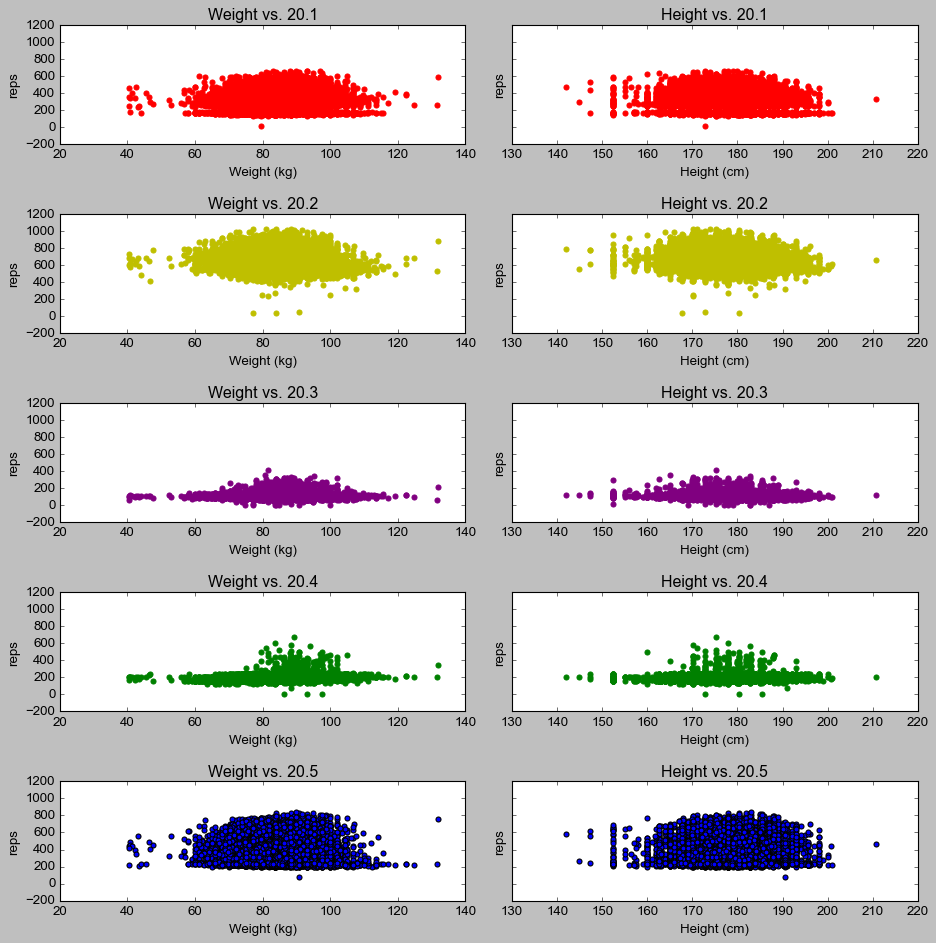

In [90]:
# scatter plots for height vs weight for each competition
with plt.style.context("classic"):
    
    fig, axes = plt.subplots(5,2, figsize = (12,12), sharey = True)
    axes[0][0].set_title("Weight vs. 20.1")
    axes[0][0].set_xlabel("Weight (kg)")
    axes[0][0].set_ylabel("reps") 
    axes[0][0].scatter(df["Weight"], df["20.1"], color = 'r')
    
    axes[0][1].set_title("Height vs. 20.1")
    axes[0][1].set_xlabel("Height (cm)")
    axes[0][1].set_ylabel("reps")
    axes[0][1].scatter(df["Height"], df["20.1"], color = 'r')
    
    axes[1][0].set_title("Weight vs. 20.2")
    axes[1][0].set_xlabel("Weight (kg)")
    axes[1][0].set_ylabel("reps") 
    axes[1][0].scatter(df["Weight"], df["20.2"], color = 'y')
    
    axes[1][1].set_title("Height vs. 20.2")
    axes[1][1].set_xlabel("Height (cm)")
    axes[1][1].set_ylabel("reps") 
    axes[1][1].scatter(df["Height"], df["20.2"], color = 'y')
    
    axes[2][0].set_title("Weight vs. 20.3")
    axes[2][0].set_xlabel("Weight (kg)")
    axes[2][0].set_ylabel("reps") 
    axes[2][0].scatter(df["Weight"], df["20.3"], color = 'purple')
    
    axes[2][1].set_title("Height vs. 20.3")
    axes[2][1].set_xlabel("Height (cm)")
    axes[2][1].set_ylabel("reps") 
    axes[2][1].scatter(df["Height"], df["20.3"], color = 'purple')
    
    axes[3][0].set_title("Weight vs. 20.4")
    axes[3][0].set_xlabel("Weight (kg)")
    axes[3][0].set_ylabel("reps") 
    axes[3][0].scatter(df["Weight"], df["20.4"], color = 'g')
    
    axes[3][1].set_title("Height vs. 20.4")
    axes[3][1].set_xlabel("Height (cm)")
    axes[3][1].set_ylabel("reps") 
    axes[3][1].scatter(df["Height"], df["20.4"], color = 'g')
    
    axes[4][0].set_title("Weight vs. 20.5")
    axes[4][0].set_xlabel("Weight (kg)")
    axes[4][0].set_ylabel("reps") 
    axes[4][0].scatter(df["Weight"], df["20.5"])
    axes[4][1].set_title("Height vs. 20.5")
    
    axes[4][1].set_xlabel("Height (cm)")
    axes[4][1].set_ylabel("reps") 
    axes[4][1].scatter(df["Height"], df["20.5"])
    plt.tight_layout()

Text(0, 0.5, 'Class')

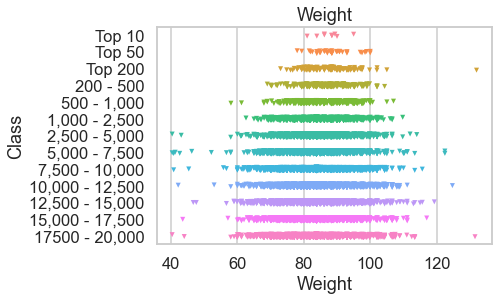

In [91]:
# Weight scatterplot after cleaning
sns.stripplot(df["Weight"], df["class"], order = order2, marker = "v")
plt.title("Weight")
plt.xlabel("Weight")
plt.ylabel("Class")

Text(0, 0.5, 'Class')

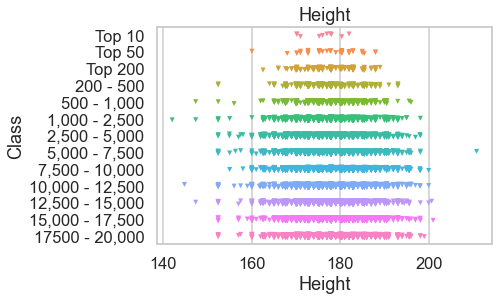

In [92]:
# Height scatterplot after cleaning
sns.stripplot(df["Height"], df["class"], order = order2, marker = "v")
plt.title("Height")
plt.xlabel("Height")
plt.ylabel("Class")

In [95]:
X = df.drop(columns = ["Rank", "class", "Name", "Country"], axis = 1)

In [96]:
y = df["class"]

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [98]:
X_train

,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5
2645,26,179.00,88.000000,433.0,890.0,153.0,235.0,726.0
5780,24,160.02,58.966960,253.0,554.0,94.0,166.0,283.0
1778,28,174.00,88.000000,175.0,554.0,126.0,200.0,450.0
19548,33,180.34,87.089664,386.0,650.0,111.0,200.0,457.0
19120,45,170.00,78.000000,173.0,578.0,101.0,163.0,248.0
...,...,...,...,...,...,...,...,...
4384,32,177.94,83.768100,162.0,646.0,117.0,203.0,438.0
9310,32,172.72,76.203456,288.0,612.0,99.0,160.0,225.0
11897,35,173.00,80.000000,297.0,554.0,95.0,169.0,227.0
17232,42,182.00,87.089664,386.0,714.0,127.0,200.0,624.0


# Decision Tree

# Add Feature Importance

In [102]:
clf = tree.DecisionTreeClassifier()

In [103]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [104]:
predict = clf.predict(X_test)

In [105]:
len(predict)

3911

In [106]:
df["Height"] = df["Height"].astype(float)

In [107]:
X_test

,Age,Height,Weight,20.1,20.2,20.3,20.4,20.5
7853,31,172.72,79.378600,167.0,663.0,128.0,200.0,355.0
10421,39,187.96,92.986360,160.0,550.0,102.0,201.0,229.0
17098,26,177.94,83.768100,407.0,619.0,115.0,202.0,352.0
13532,32,185.42,88.450440,380.0,716.0,115.0,201.0,498.0
14111,20,170.18,78.925008,413.0,614.0,101.0,181.0,347.0
...,...,...,...,...,...,...,...,...
14732,29,185.00,85.000000,262.0,680.0,103.0,167.0,484.0
7630,36,190.00,98.000000,258.0,548.0,99.0,177.0,230.0
2719,34,173.00,74.000000,167.0,583.0,111.0,200.0,571.0
7712,22,170.18,74.842680,148.0,581.0,102.0,165.0,355.0


In [108]:
clf.score(X_test, y_test)

0.6752748657632319

In [109]:
importances = clf.feature_importances_

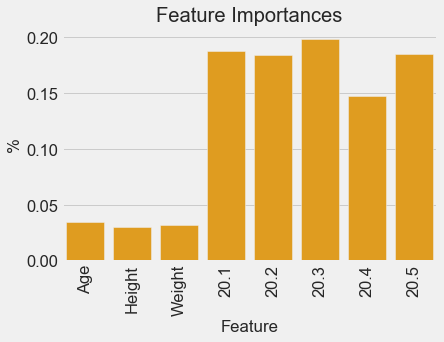

In [113]:
with plt.style.context("fivethirtyeight"):
    sns.barplot(X_test.columns, importances, color = 'orange')
    plt.xticks(rotation = 'vertical');
    plt.ylabel("%");
    plt.xlabel("Feature")
    plt.title("Feature Importances")

# Neural Network

In [257]:
# first trial
model = models.Sequential()
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))

In [258]:
 model.compile(
        optimizer=keras.optimizers.Adam(
            1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [259]:
df.dtypes

Name        object
Country     object
Age          int64
Height     float64
Weight     float64
20.1       float64
20.2       float64
20.3       float64
20.4       float64
20.5       float64
Rank         int64
class       object
dtype: object

In [260]:
y_train

12455    10,000 - 12,500
2267     12,500 - 15,000
13833      5,000 - 7,500
4165              Top 10
4842     12,500 - 15,000
              ...       
3749      17500 - 20,000
3849     12,500 - 15,000
7620     10,000 - 12,500
19106     17500 - 20,000
15530      1,000 - 2,500
Name: class, Length: 15640, dtype: object

In [261]:
y_train.dtypes

dtype('O')

In [262]:
# standardizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [263]:
# changing y variables to categorical
lb = LabelBinarizer()
lb.fit(y_train)
y_train_lb = to_categorical(lb.transform(y_train))[:,:,1]
y_test_lb = to_categorical(lb.transform(y_test))[:, :, 1]


In [264]:
y_train_lb

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [265]:
#fitting the first model
model1 = model.fit(X_train, y_train_lb, epochs = 150,
                         batch_size = 256, validation_split=.1,)

Epoch 1/150
55/55 [==============================] - 2s 12ms/step - loss: 2.0815 - accuracy: 0.3020 - val_loss: 1.2648 - val_accuracy: 0.5090
Epoch 2/150
55/55 [==============================] - 0s 7ms/step - loss: 1.1535 - accuracy: 0.5237 - val_loss: 0.9963 - val_accuracy: 0.5889
Epoch 3/150
55/55 [==============================] - 0s 7ms/step - loss: 0.9546 - accuracy: 0.5944 - val_loss: 0.9055 - val_accuracy: 0.6010
Epoch 4/150
55/55 [==============================] - 0s 6ms/step - loss: 0.8523 - accuracy: 0.6326 - val_loss: 0.8381 - val_accuracy: 0.6381
Epoch 5/150
55/55 [==============================] - 0s 6ms/step - loss: 0.8025 - accuracy: 0.6554 - val_loss: 0.8286 - val_accuracy: 0.6439
Epoch 6/150
55/55 [==============================] - 0s 6ms/step - loss: 0.7601 - accuracy: 0.6666 - val_loss: 0.7824 - val_accuracy: 0.6451
Epoch 7/150
55/55 [==============================] - 0s 7ms/step - loss: 0.7340 - accuracy: 0.6795 - val_loss: 0.7507 - val_accuracy: 0.6733
Epoch 8/150


Epoch 59/150
55/55 [==============================] - 0s 5ms/step - loss: 0.3484 - accuracy: 0.8577 - val_loss: 0.5139 - val_accuracy: 0.7807
Epoch 60/150
55/55 [==============================] - 0s 6ms/step - loss: 0.3509 - accuracy: 0.8492 - val_loss: 0.4815 - val_accuracy: 0.7973
Epoch 61/150
55/55 [==============================] - 0s 5ms/step - loss: 0.3350 - accuracy: 0.8594 - val_loss: 0.4664 - val_accuracy: 0.8005
Epoch 62/150
55/55 [==============================] - 0s 5ms/step - loss: 0.3296 - accuracy: 0.8634 - val_loss: 0.4653 - val_accuracy: 0.8075
Epoch 63/150
55/55 [==============================] - 0s 6ms/step - loss: 0.3290 - accuracy: 0.8662 - val_loss: 0.4699 - val_accuracy: 0.8037
Epoch 64/150
55/55 [==============================] - 0s 6ms/step - loss: 0.3234 - accuracy: 0.8614 - val_loss: 0.4654 - val_accuracy: 0.7992
Epoch 65/150
55/55 [==============================] - 0s 5ms/step - loss: 0.3321 - accuracy: 0.8596 - val_loss: 0.4617 - val_accuracy: 0.8043
Epoch 

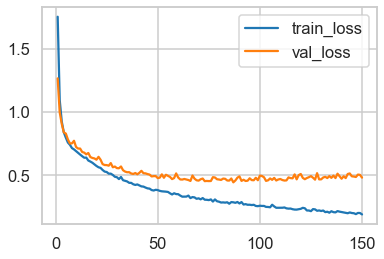

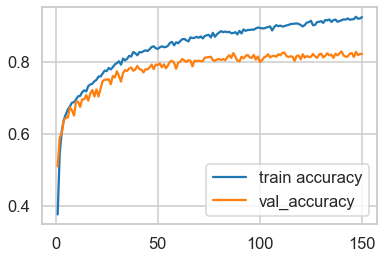

In [266]:
# checking for signs of overfitting
history = model1.history
plt.figure()
plt.plot(np.arange(1,151,1), history["loss"], label = "train_loss")
plt.plot(np.arange(1,151,1), history["val_loss"], label = "val_loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(np.arange(1,151,1), history["accuracy"], label = "train accuracy")
plt.plot(np.arange(1,151,1), history["val_accuracy"], label = "val_accuracy")
plt.legend()
plt.show()

In [267]:
model.evaluate(X_test, y_test_lb)

123/123 [==============================] - 0s 2ms/step - loss: 0.5060 - accuracy: 0.8302


[0.5060285925865173, 0.8302224278450012]

In [268]:
df["class"].unique()

array(['12,500 - 15,000', '17500 - 20,000', '1,000 - 2,500',
       '7,500 - 10,000', '2,500 - 5,000', '5,000 - 7,500',
       '15,000 - 17,500', '10,000 - 12,500', 'Top 200', '200 - 500',
       '500 - 1,000', 'Top 10', 'Top 50'], dtype=object)

In [269]:
# CREATING CONFITION MATRIX
pred = model.predict(X_test).argmax(axis = 1)
y_test_labels = y_test_lb.argmax(axis = 1)
matrix = confusion_matrix(y_test_labels, pred)
matrix

array([[250,   0,   0,   0,   0,  25,   0,   0,  14,   0,   0,   0,   0],
       [  0, 429,  59,   0,   0,   0,   0,   0,   0,  21,   0,   0,   0],
       [  0,  35, 358,  65,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  34, 429,  60,   1,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,  64, 388,   0,   0,   1,   0,   0,   0,   0,   0],
       [ 13,   0,   0,   0,   0, 459,   0,  52,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  39,   0,  19,   0,   0,   3,   0],
       [  0,   0,   0,   0,   0,  19,   0, 402,   0,  44,   0,   0,   0],
       [ 11,   0,   0,   0,   0,   0,   3,   0,  94,   0,   0,   0,   0],
       [  0,  52,   0,   0,   0,   0,   0,  56,   0, 367,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2],
       [  0,   0,   0,   0,   0,   0,   5,   0,   0,   0,   0,  30,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   2]])

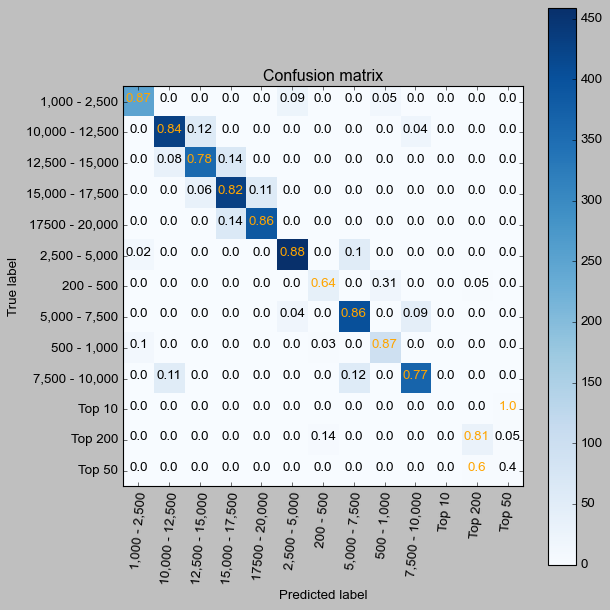

In [288]:
# FUNCTION FROM SKLEARNS WEBSITE FOR NEURAL NETWORK CONFUSION MATRIX
with plt.style.context("classic"):
    def plot_confusion_matrix(cm, class_names):
        """
        Returns a matplotlib figure containing the plotted confusion matrix.

        Args:
           cm (array, shape = [n, n]): a confusion matrix of integer classes
           class_names (array, shape = [n]): String names of the integer classes
        """

        figure = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=85)
        plt.yticks(tick_marks, class_names)

        # Normalize the confusion matrix.
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.

        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "orange" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    plot_confusion_matrix(matrix, sorted(df["class"].unique()))

In [271]:
def build_classifier():
    classifier = models.Sequential()
    classifier.add(layers.Dense(128, activation='relu'))
    classifier.add(layers.Dense(512, activation='relu'))
    classifier.add(layers.Dense(32, activation='relu'))
    classifier.add(layers.Dense(13, activation='softmax'))
    classifier.compile(optimizer=keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return classifier

In [272]:
cv = ShuffleSplit(n_splits = 3, test_size = .25)
classifier = KerasClassifier(build_classifier, epochs = 150,
                         batch_size = 256, validation_split=.1)
accuracies = cross_val_score(classifier, scaler.transform(X), to_categorical(lb.transform(y))[:, :, 1], cv = cv)

Epoch 1/150
52/52 [==============================] - 1s 11ms/step - loss: 2.1067 - accuracy: 0.2962 - val_loss: 1.2139 - val_accuracy: 0.5099
Epoch 2/150
52/52 [==============================] - 0s 8ms/step - loss: 1.1487 - accuracy: 0.5381 - val_loss: 1.0177 - val_accuracy: 0.5746
Epoch 3/150
52/52 [==============================] - 0s 7ms/step - loss: 0.9325 - accuracy: 0.6047 - val_loss: 0.8948 - val_accuracy: 0.6326
Epoch 4/150
52/52 [==============================] - 0s 7ms/step - loss: 0.8413 - accuracy: 0.6371 - val_loss: 0.8372 - val_accuracy: 0.6367
Epoch 5/150
52/52 [==============================] - 0s 7ms/step - loss: 0.8009 - accuracy: 0.6523 - val_loss: 0.8232 - val_accuracy: 0.6326
Epoch 6/150
52/52 [==============================] - 0s 7ms/step - loss: 0.7564 - accuracy: 0.6653 - val_loss: 0.7858 - val_accuracy: 0.6524
Epoch 7/150
52/52 [==============================] - 0s 7ms/step - loss: 0.7385 - accuracy: 0.6732 - val_loss: 0.7566 - val_accuracy: 0.6639
Epoch 8/150


Epoch 59/150
52/52 [==============================] - 0s 7ms/step - loss: 0.3612 - accuracy: 0.8504 - val_loss: 0.4586 - val_accuracy: 0.8248
Epoch 60/150
52/52 [==============================] - 0s 9ms/step - loss: 0.3567 - accuracy: 0.8523 - val_loss: 0.4541 - val_accuracy: 0.8214
Epoch 61/150
52/52 [==============================] - 0s 7ms/step - loss: 0.3619 - accuracy: 0.8545 - val_loss: 0.4556 - val_accuracy: 0.8194
Epoch 62/150
52/52 [==============================] - 0s 6ms/step - loss: 0.3647 - accuracy: 0.8519 - val_loss: 0.4565 - val_accuracy: 0.8085
Epoch 63/150
52/52 [==============================] - 0s 7ms/step - loss: 0.3665 - accuracy: 0.8479 - val_loss: 0.4514 - val_accuracy: 0.8180
Epoch 64/150
52/52 [==============================] - 0s 5ms/step - loss: 0.3556 - accuracy: 0.8522 - val_loss: 0.4475 - val_accuracy: 0.8309
Epoch 65/150
52/52 [==============================] - 0s 5ms/step - loss: 0.3465 - accuracy: 0.8576 - val_loss: 0.4675 - val_accuracy: 0.8119
Epoch 

Epoch 23/150
52/52 [==============================] - 0s 6ms/step - loss: 0.5715 - accuracy: 0.7512 - val_loss: 0.6337 - val_accuracy: 0.7157
Epoch 24/150
52/52 [==============================] - 0s 8ms/step - loss: 0.5507 - accuracy: 0.7640 - val_loss: 0.6346 - val_accuracy: 0.7294
Epoch 25/150
52/52 [==============================] - 0s 7ms/step - loss: 0.5455 - accuracy: 0.7661 - val_loss: 0.6121 - val_accuracy: 0.7267
Epoch 26/150
52/52 [==============================] - 0s 5ms/step - loss: 0.5466 - accuracy: 0.7638 - val_loss: 0.6001 - val_accuracy: 0.7342
Epoch 27/150
52/52 [==============================] - 0s 5ms/step - loss: 0.5233 - accuracy: 0.7728 - val_loss: 0.6166 - val_accuracy: 0.7130
Epoch 28/150
52/52 [==============================] - 0s 6ms/step - loss: 0.5368 - accuracy: 0.7669 - val_loss: 0.5984 - val_accuracy: 0.7267
Epoch 29/150
52/52 [==============================] - 0s 5ms/step - loss: 0.5222 - accuracy: 0.7730 - val_loss: 0.5874 - val_accuracy: 0.7430
Epoch 

Epoch 81/150
52/52 [==============================] - 0s 7ms/step - loss: 0.3063 - accuracy: 0.8659 - val_loss: 0.5128 - val_accuracy: 0.7907
Epoch 82/150
52/52 [==============================] - 0s 7ms/step - loss: 0.2947 - accuracy: 0.8808 - val_loss: 0.5327 - val_accuracy: 0.7819
Epoch 83/150
52/52 [==============================] - 0s 6ms/step - loss: 0.3169 - accuracy: 0.8650 - val_loss: 0.5531 - val_accuracy: 0.7703
Epoch 84/150
52/52 [==============================] - 0s 6ms/step - loss: 0.2880 - accuracy: 0.8854 - val_loss: 0.5067 - val_accuracy: 0.7914
Epoch 85/150
52/52 [==============================] - 1s 14ms/step - loss: 0.2890 - accuracy: 0.8823 - val_loss: 0.5241 - val_accuracy: 0.7853
Epoch 86/150
52/52 [==============================] - 0s 10ms/step - loss: 0.2849 - accuracy: 0.8852 - val_loss: 0.5370 - val_accuracy: 0.7812
Epoch 87/150
52/52 [==============================] - 1s 13ms/step - loss: 0.2793 - accuracy: 0.8862 - val_loss: 0.5219 - val_accuracy: 0.7873
Epo

52/52 [==============================] - 0s 7ms/step - loss: 0.4032 - accuracy: 0.8367 - val_loss: 0.5053 - val_accuracy: 0.7832
Epoch 46/150
52/52 [==============================] - 0s 6ms/step - loss: 0.4050 - accuracy: 0.8325 - val_loss: 0.4906 - val_accuracy: 0.7948
Epoch 47/150
52/52 [==============================] - 0s 6ms/step - loss: 0.4146 - accuracy: 0.8287 - val_loss: 0.5420 - val_accuracy: 0.7648
Epoch 48/150
52/52 [==============================] - 0s 6ms/step - loss: 0.4099 - accuracy: 0.8275 - val_loss: 0.4978 - val_accuracy: 0.7955
Epoch 49/150
52/52 [==============================] - 0s 7ms/step - loss: 0.3927 - accuracy: 0.8386 - val_loss: 0.4903 - val_accuracy: 0.7914
Epoch 50/150
52/52 [==============================] - 0s 6ms/step - loss: 0.3892 - accuracy: 0.8429 - val_loss: 0.4989 - val_accuracy: 0.7989
Epoch 51/150
52/52 [==============================] - 0s 6ms/step - loss: 0.3897 - accuracy: 0.8392 - val_loss: 0.4854 - val_accuracy: 0.7975
Epoch 52/150
52/52 

Epoch 103/150
52/52 [==============================] - 0s 6ms/step - loss: 0.2576 - accuracy: 0.8936 - val_loss: 0.4716 - val_accuracy: 0.8200
Epoch 104/150
52/52 [==============================] - 0s 6ms/step - loss: 0.2447 - accuracy: 0.9038 - val_loss: 0.5098 - val_accuracy: 0.7969
Epoch 105/150
52/52 [==============================] - 0s 6ms/step - loss: 0.2578 - accuracy: 0.8945 - val_loss: 0.4650 - val_accuracy: 0.8248
Epoch 106/150
52/52 [==============================] - 0s 6ms/step - loss: 0.2597 - accuracy: 0.8954 - val_loss: 0.4636 - val_accuracy: 0.8146
Epoch 107/150
52/52 [==============================] - 0s 6ms/step - loss: 0.2410 - accuracy: 0.9014 - val_loss: 0.4668 - val_accuracy: 0.8228
Epoch 108/150
52/52 [==============================] - 0s 7ms/step - loss: 0.2546 - accuracy: 0.8948 - val_loss: 0.5482 - val_accuracy: 0.7914
Epoch 109/150
52/52 [==============================] - 0s 7ms/step - loss: 0.2689 - accuracy: 0.8886 - val_loss: 0.5232 - val_accuracy: 0.8037

In [274]:
accuracies.mean()

0.8151254653930664

# Keras Tuner

In [ ]:
#Setting up Keras Tuner

def build_model(hp):
  model = Sequential()
  for i in range(hp.Int("first layer", min_value = 0, max_value = 3)):
    model.add(layers.Dense(hp.Choice(f"layer {i} features", [32, 64, 128, 256, 512]), activation='relu'))
  model.add(layers.Dense(hp.Choice("second", [32, 64, 128, 256, 512]), activation='relu'))
  for i in range(hp.Int("second layer", min_value = 0, max_value = 1)):
    model.add(layers.Dropout(hp.Choice("dropout", [.1, .15, .2, .25])))
  model.add(layers.Dense(hp.Choice("third", [32, 64, 128, 256, 512]), activation='relu'))
  model.add(layers.Dense(hp.Choice("fourth", [32, 64, 128, 256, 512]), activation='relu'))
  model.add(layers.Dense(13, activation='sigmoid'))
  model.compile(
    optimizer=keras.optimizers.Adam(
      1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
    
  model.compile(
        optimizer=keras.optimizers.Adam(
            1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
  return model

              
tuner = RandomSearch(build_model, objective = 'val_accuracy', max_trials= 4000,
overwrite = True)
tuner.search(X_train, y_train_lb, epochs = 100, batch_size = 256, \
validation_split = (.1))


<img src="Images/Keras_tuner">

In [277]:
model = Sequential()
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(13, activation='sigmoid'))
model.compile(
optimizer=keras.optimizers.Adam(
  1e-3),
loss='categorical_crossentropy',
metrics=['accuracy'])

model.compile(
    optimizer=keras.optimizers.Adam(
        1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [278]:
model2 = model.fit(X_train, y_train_lb, epochs = 150,
                         batch_size = 256, validation_split=.1,)

Epoch 1/150
55/55 [==============================] - 1s 14ms/step - loss: 1.9455 - accuracy: 0.3086 - val_loss: 1.0388 - val_accuracy: 0.5416
Epoch 2/150
55/55 [==============================] - 1s 9ms/step - loss: 0.9742 - accuracy: 0.5845 - val_loss: 0.8326 - val_accuracy: 0.6324
Epoch 3/150
55/55 [==============================] - 1s 11ms/step - loss: 0.8414 - accuracy: 0.6309 - val_loss: 0.7805 - val_accuracy: 0.6541
Epoch 4/150
55/55 [==============================] - 1s 9ms/step - loss: 0.7969 - accuracy: 0.6417 - val_loss: 0.7726 - val_accuracy: 0.6509
Epoch 5/150
55/55 [==============================] - 1s 10ms/step - loss: 0.7675 - accuracy: 0.6579 - val_loss: 0.7497 - val_accuracy: 0.6669
Epoch 6/150
55/55 [==============================] - 1s 9ms/step - loss: 0.7718 - accuracy: 0.6461 - val_loss: 0.7159 - val_accuracy: 0.6694
Epoch 7/150
55/55 [==============================] - 1s 9ms/step - loss: 0.7293 - accuracy: 0.6699 - val_loss: 0.7253 - val_accuracy: 0.6643
Epoch 8/15

55/55 [==============================] - 0s 9ms/step - loss: 0.2735 - accuracy: 0.8829 - val_loss: 0.3676 - val_accuracy: 0.8491
Epoch 116/150
55/55 [==============================] - 0s 8ms/step - loss: 0.2705 - accuracy: 0.8843 - val_loss: 0.3706 - val_accuracy: 0.8408
Epoch 117/150
55/55 [==============================] - 1s 9ms/step - loss: 0.2759 - accuracy: 0.8809 - val_loss: 0.3722 - val_accuracy: 0.8331
Epoch 118/150
55/55 [==============================] - 0s 8ms/step - loss: 0.2631 - accuracy: 0.8855 - val_loss: 0.3883 - val_accuracy: 0.8421
Epoch 119/150
55/55 [==============================] - 0s 8ms/step - loss: 0.2663 - accuracy: 0.8871 - val_loss: 0.3665 - val_accuracy: 0.8414
Epoch 120/150
55/55 [==============================] - 0s 8ms/step - loss: 0.2615 - accuracy: 0.8868 - val_loss: 0.3651 - val_accuracy: 0.8459
Epoch 121/150
55/55 [==============================] - 0s 8ms/step - loss: 0.2737 - accuracy: 0.8849 - val_loss: 0.3514 - val_accuracy: 0.8549
Epoch 122/150

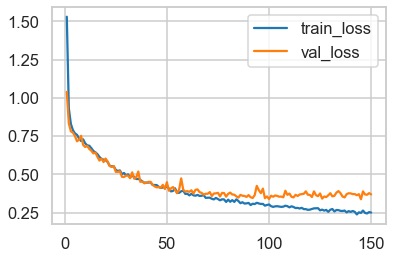

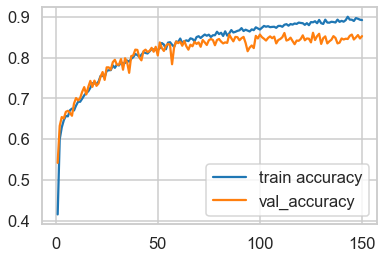

In [279]:
# checking for signs of overfitting
history = model2.history
plt.figure()
plt.plot(np.arange(1,151,1), history["loss"], label = "train_loss")
plt.plot(np.arange(1,151,1), history["val_loss"], label = "val_loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(np.arange(1,151,1), history["accuracy"], label = "train accuracy")
plt.plot(np.arange(1,151,1), history["val_accuracy"], label = "val_accuracy")
plt.legend()
plt.show()

In [280]:
model.evaluate(X_test, y_test_lb)

123/123 [==============================] - 0s 2ms/step - loss: 0.3995 - accuracy: 0.8451


[0.39952075481414795, 0.8450524210929871]

In [281]:
def build_classifier2():
    model = Sequential()
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(13, activation='sigmoid'))
    model.compile(
    optimizer=keras.optimizers.Adam(
    1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

    model.compile(
    optimizer=keras.optimizers.Adam(
        1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
    return model

In [282]:
classifier = KerasClassifier(build_classifier2, epochs = 150,
                         batch_size = 256, validation_split=.1)
accuracies2 = cross_val_score(classifier, scaler.transform(X), to_categorical(lb.transform(y))[:, :, 1], cv = 3)

Epoch 1/150
46/46 [==============================] - 1s 13ms/step - loss: 1.9824 - accuracy: 0.3007 - val_loss: 1.1707 - val_accuracy: 0.5084
Epoch 2/150
46/46 [==============================] - 0s 10ms/step - loss: 1.0507 - accuracy: 0.5451 - val_loss: 0.9470 - val_accuracy: 0.5844
Epoch 3/150
46/46 [==============================] - 0s 10ms/step - loss: 0.8807 - accuracy: 0.6103 - val_loss: 0.8876 - val_accuracy: 0.6166
Epoch 4/150
46/46 [==============================] - 0s 9ms/step - loss: 0.8279 - accuracy: 0.6286 - val_loss: 0.8280 - val_accuracy: 0.6296
Epoch 5/150
46/46 [==============================] - 1s 12ms/step - loss: 0.7896 - accuracy: 0.6461 - val_loss: 0.7735 - val_accuracy: 0.6488
Epoch 6/150
46/46 [==============================] - 1s 12ms/step - loss: 0.7663 - accuracy: 0.6619 - val_loss: 0.7513 - val_accuracy: 0.6664
Epoch 7/150
46/46 [==============================] - 0s 10ms/step - loss: 0.7443 - accuracy: 0.6684 - val_loss: 0.7456 - val_accuracy: 0.6572
Epoch 8

46/46 [==============================] - 0s 8ms/step - loss: 0.2773 - accuracy: 0.8800 - val_loss: 0.4184 - val_accuracy: 0.8328
Epoch 116/150
46/46 [==============================] - 0s 8ms/step - loss: 0.2788 - accuracy: 0.8775 - val_loss: 0.3754 - val_accuracy: 0.8551
Epoch 117/150
46/46 [==============================] - 0s 8ms/step - loss: 0.2576 - accuracy: 0.8910 - val_loss: 0.4478 - val_accuracy: 0.8113
Epoch 118/150
46/46 [==============================] - 0s 9ms/step - loss: 0.2806 - accuracy: 0.8829 - val_loss: 0.4023 - val_accuracy: 0.8336
Epoch 119/150
46/46 [==============================] - 0s 8ms/step - loss: 0.2691 - accuracy: 0.8872 - val_loss: 0.4222 - val_accuracy: 0.8236
Epoch 120/150
46/46 [==============================] - 0s 9ms/step - loss: 0.2709 - accuracy: 0.8889 - val_loss: 0.3980 - val_accuracy: 0.8374
Epoch 121/150
46/46 [==============================] - 0s 9ms/step - loss: 0.2700 - accuracy: 0.8827 - val_loss: 0.3887 - val_accuracy: 0.8451
Epoch 122/150

Epoch 22/150
46/46 [==============================] - 0s 8ms/step - loss: 0.5893 - accuracy: 0.7404 - val_loss: 0.6355 - val_accuracy: 0.7101
Epoch 23/150
46/46 [==============================] - 0s 8ms/step - loss: 0.5962 - accuracy: 0.7391 - val_loss: 0.6210 - val_accuracy: 0.7255
Epoch 24/150
46/46 [==============================] - 0s 8ms/step - loss: 0.5942 - accuracy: 0.7388 - val_loss: 0.5747 - val_accuracy: 0.7400
Epoch 25/150
46/46 [==============================] - 0s 8ms/step - loss: 0.5813 - accuracy: 0.7391 - val_loss: 0.5847 - val_accuracy: 0.7385
Epoch 26/150
46/46 [==============================] - 0s 8ms/step - loss: 0.5757 - accuracy: 0.7425 - val_loss: 0.6017 - val_accuracy: 0.7308
Epoch 27/150
46/46 [==============================] - 0s 8ms/step - loss: 0.5740 - accuracy: 0.7436 - val_loss: 0.5947 - val_accuracy: 0.7431
Epoch 28/150
46/46 [==============================] - 1s 11ms/step - loss: 0.5580 - accuracy: 0.7573 - val_loss: 0.5651 - val_accuracy: 0.7431
Epoch

Epoch 80/150
46/46 [==============================] - 0s 8ms/step - loss: 0.3233 - accuracy: 0.8636 - val_loss: 0.3899 - val_accuracy: 0.8405
Epoch 81/150
46/46 [==============================] - 0s 8ms/step - loss: 0.3264 - accuracy: 0.8586 - val_loss: 0.4647 - val_accuracy: 0.8098
Epoch 82/150
46/46 [==============================] - 0s 8ms/step - loss: 0.3503 - accuracy: 0.8471 - val_loss: 0.3899 - val_accuracy: 0.8290
Epoch 83/150
46/46 [==============================] - 0s 8ms/step - loss: 0.3312 - accuracy: 0.8565 - val_loss: 0.4022 - val_accuracy: 0.8336
Epoch 84/150
46/46 [==============================] - 0s 8ms/step - loss: 0.3101 - accuracy: 0.8682 - val_loss: 0.3798 - val_accuracy: 0.8420
Epoch 85/150
46/46 [==============================] - 0s 8ms/step - loss: 0.3278 - accuracy: 0.8577 - val_loss: 0.3643 - val_accuracy: 0.8512
Epoch 86/150
46/46 [==============================] - 0s 9ms/step - loss: 0.3152 - accuracy: 0.8688 - val_loss: 0.3848 - val_accuracy: 0.8328
Epoch 

46/46 [==============================] - 0s 8ms/step - loss: 0.4294 - accuracy: 0.8134 - val_loss: 0.4703 - val_accuracy: 0.8183
Epoch 45/150
46/46 [==============================] - 0s 8ms/step - loss: 0.4254 - accuracy: 0.8161 - val_loss: 0.4884 - val_accuracy: 0.8044
Epoch 46/150
46/46 [==============================] - 0s 8ms/step - loss: 0.4460 - accuracy: 0.8020 - val_loss: 0.4775 - val_accuracy: 0.8206
Epoch 47/150
46/46 [==============================] - 0s 8ms/step - loss: 0.4157 - accuracy: 0.8227 - val_loss: 0.4488 - val_accuracy: 0.8244
Epoch 48/150
46/46 [==============================] - 0s 8ms/step - loss: 0.4144 - accuracy: 0.8162 - val_loss: 0.4729 - val_accuracy: 0.8029
Epoch 49/150
46/46 [==============================] - 0s 8ms/step - loss: 0.4207 - accuracy: 0.8174 - val_loss: 0.4607 - val_accuracy: 0.8121
Epoch 50/150
46/46 [==============================] - 0s 8ms/step - loss: 0.4167 - accuracy: 0.8220 - val_loss: 0.4673 - val_accuracy: 0.8037
Epoch 51/150
46/46 

In [283]:
accuracies2.mean()

0.8521303335825602

In [289]:
pred = model.predict(X_test).argmax(axis = 1)
y_test_labels = y_test_lb.argmax(axis = 1)
matrix = confusion_matrix(y_test_labels, pred)
matrix

array([[246,   0,   0,   0,   0,  33,   1,   0,   9,   0,   0,   0,   0],
       [  0, 435,  52,   0,   0,   0,   0,   0,   0,  22,   0,   0,   0],
       [  0,  23, 378,  56,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  20, 427,  77,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   1, 377,  73,   0,   0,   0,   0,   1,   0,   0,   0],
       [  9,   0,   0,   0,   0, 471,   0,  44,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  44,   0,  15,   0,   0,   2,   0],
       [  0,   0,   0,   0,   0,  20,   0, 387,   0,  58,   0,   0,   0],
       [ 12,   0,   0,   0,   0,   0,   7,   0,  89,   0,   0,   0,   0],
       [  0,  50,   0,   0,   0,   0,   0,  20,   0, 405,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1],
       [  0,   0,   0,   0,   0,   0,  11,   0,   0,   0,   0,  23,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   4]])

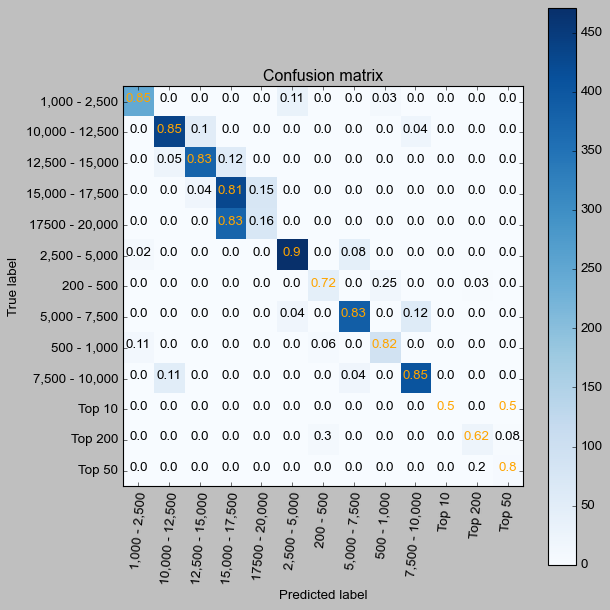

In [290]:
# FUNCTION FROM SKLEARNS WEBSITE FOR NEURAL NETWORK CONFUSION MATRIX
with plt.style.context("classic"):
    def plot_confusion_matrix(cm, class_names):
        """
        Returns a matplotlib figure containing the plotted confusion matrix.

        Args:
           cm (array, shape = [n, n]): a confusion matrix of integer classes
           class_names (array, shape = [n]): String names of the integer classes
        """

        figure = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=85)
        plt.yticks(tick_marks, class_names)

        # Normalize the confusion matrix.
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.

        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "orange" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    plot_confusion_matrix(matrix, sorted(df["class"].unique()))

# Random Forest

In [238]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7528061224489796

In [240]:
gs_clf = RandomForestClassifier()

gs_clf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}
gs_clf_search = GridSearchCV(gs_clf, gs_clf_param_grid, cv=3)
gs_clf_search.fit(X_train, y_train)
gs_clf_search.score(X_test, y_test)

0.7579081632653061

In [242]:
gs_clf_search.best_score_

0.7672829091824607

In [244]:
gs_clf_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

# Gradient Boost

In [251]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [253]:
gb.score(X_test, y_test)

0.7362244897959184

In [ ]:
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

gb = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


# SVM

In [154]:
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [155]:
svm.score(X_test, y_test)

0.6966836734693878

# Logistic Regression

In [110]:
lg = LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

In [111]:
lg.score(X_test, y_test)

0.6380102040816327